In [1]:
# import libraries
import numpy as np
import pandas as pd
import os
import glob
import re
import matplotlib.pyplot as plt
import seaborn as sns
import re

from pathlib import Path

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

%load_ext autoreload
%autoreload 2

# load in directories
from experiment_code.constants import Defaults
#from experiment_code.preprocess import CoRTScaling
from experiment_code.visualization.visualize import CoRTLanguageExp


!pip install urllib3
import urllib.request, json
import requests

#pip install py_linq

## Non-CoRT Stimuli

In [2]:
# get low and high cloze prob
def clean_df(dataframe):
    dataframe.columns = dataframe.columns.str.replace(' ', '')
    #dataframe.rows = dataframe.rows.str.replace(' ', '')
    dataframe.columns = dataframe.columns.str.replace('?', '')
    
    dataframe = dataframe.query('NORMED==" YES"')
    
    df_min = dataframe.groupby(['CUE'])['FSG'].apply(lambda x: x.min()).reset_index()
    df_min = df_min.merge(df, on=['CUE', 'FSG']).add_prefix('MIN_')
    df_min = df_min.groupby('MIN_CUE').last().reset_index()

    df_max = dataframe.groupby(['CUE'])['FSG'].apply(lambda x: x.max()).reset_index()
    df_max = df_max.merge(df, on=['CUE', 'FSG']).add_prefix('MAX_')
    df_max = df_max.groupby('MAX_CUE').last().reset_index()

    df_concat = pd.concat([df_min, df_max], axis=1).reset_index(drop=True)
    
    return df_concat

In [3]:
# read in word databses
os.chdir(Defaults.STIM_DIR)
file_list = glob.glob('cue_target_pairs*')

df_all = pd.DataFrame()
for file in file_list:
    df = pd.read_csv(file)
    
    df_grouped = clean_df(dataframe=df)
    df_all = pd.concat([df_all, df_grouped])

In [4]:
df_exp_noncort = df_all.filter({'MAX_CUE','MAX_TARGET','MAX_FSG','MAX_#P','MAX_#G','MIN_CUE','MIN_TARGET','MIN_FSG','MIN_#P','MIN_#G'})
#only going up to 'H'?
#~500 for A-B df
df_exp_noncort.head()

,MAX_#G,MIN_#G,MIN_CUE,MAX_#P,MAX_FSG,MIN_FSG,MIN_#P,MAX_TARGET,MAX_CUE,MIN_TARGET
0,152.0,152.0,A,10.0,0.066,0.013,2.0,THE,A,WORD
1,152.0,152.0,AARDVARK,49.0,0.322,0.013,2.0,ANIMAL,AARDVARK,ZOO
2,152.0,152.0,ABDOMEN,86.0,0.566,0.013,2.0,STOMACH,ABDOMEN,SIX PACK
3,150.0,150.0,ABDUCT,68.0,0.453,0.013,2.0,KIDNAP,ABDUCT,OPEN
4,143.0,143.0,ABILITY,17.0,0.119,0.014,2.0,CAPABILITY,ABILITY,WORK


In [204]:
# only allow 1 target word
df_exp_noncort = df_exp_noncort.drop_duplicates(subset=['MAX_TARGET'])

In [205]:
#look at overlap between last word of CoRT and cues/targets - 1st

#want even bell-shaped range of FSG
#50/50/50 low/med/high

In [206]:
def fsg_distribution(dataframe, x):
    """ plots distribution of cloze probabilities
        Args:
            dataframe
    """
    plt.figure(figsize=(10,10))

    sns.distplot(dataframe[x])
    plt.xlabel(x, fontsize=20)
    plt.title('Distribution of FSG', fontsize=20);
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20);
    plt.show()                          

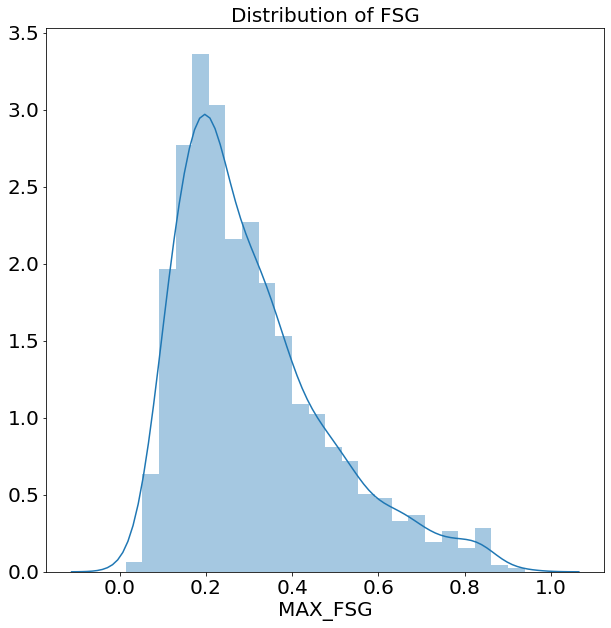

In [207]:
fsg_distribution(df_exp_noncort, 'MAX_FSG')

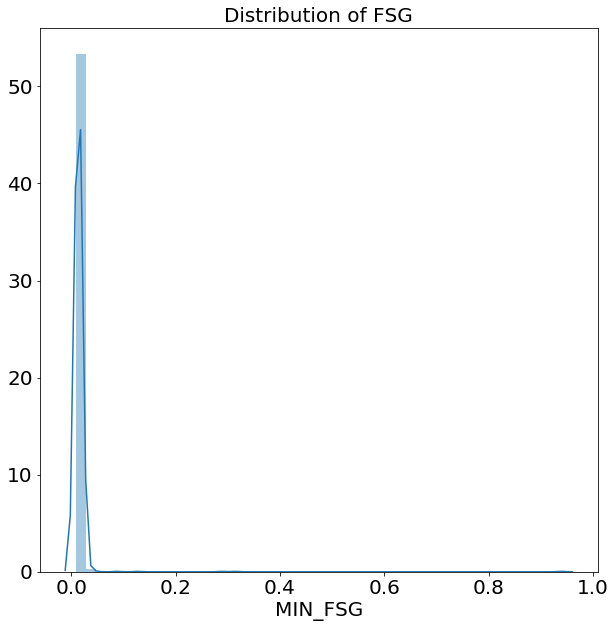

In [208]:
fsg_distribution(df_exp_noncort, 'MIN_FSG')

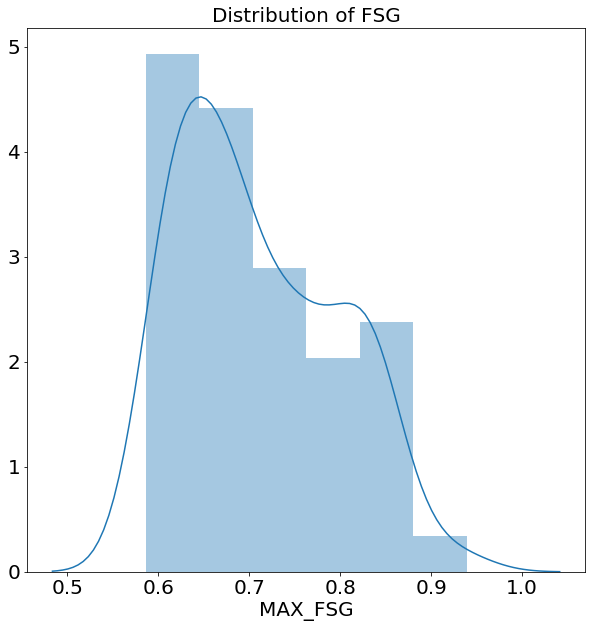

In [209]:
df_exp_noncort_random = df_exp_noncort.sample(frac = 1)
df_exp_noncort_max = df_exp_noncort_random.sort_values("MAX_FSG", ascending = False).head(100)
fsg_distribution(df_exp_noncort_max, 'MAX_FSG')

## CoRT Stimuli

In [10]:
#load current database (for ones w/ RT data)
cort = CoRTLanguageExp()
df_og_extremes = cort.load_dataframe()

In [222]:
df_og_extremes.columns
#df_og_extremes['participant_id']

Index(['local_date', 'experiment_id', 'experiment_version', 'participant_id',
       'participant_private_id', 'task_name', 'task_version',
       'spreadsheet_version', 'spreadsheet_row', 'sentence_num', 'zone_type',
       'rt', 'response', 'attempt', 'correct', 'incorrect', 'display',
       'block_num', 'randomise_blocks', 'full_sentence', 'last_word',
       'sampled', 'CoRT_descript', 'CoRT_mean', 'condition_name', 'CoRT_std',
       'cloze_descript', 'cloze_probability', 'dataset', 'random_word',
       'target_word', 'word_count', 'group', 'cause_effect', 'dynamic_verb',
       'orientation', 'negative', 'tense', 'spelling_modified', 'trial_type',
       'version', 'version_descript', 'group_condition_name',
       'group_CoRT_condition', 'group_trial_type'],
      dtype='object')

In [12]:
#rename cloze column/values for later concat
df_og_extremes['condition_name'] = df_og_extremes['condition_name'].replace({'hard': 'low cloze', 'easy':'high cloze'})
df_og_extremes = df_og_extremes.rename({'condition_name':'cloze_descript'})
df_og_extremes['cloze_descript']

311      high cloze
324      high cloze
337       low cloze
350       low cloze
363       low cloze
            ...    
46247     low cloze
46260    high cloze
46272    high cloze
46284    high cloze
46296    high cloze
Name: cloze_descript, Length: 10560, dtype: object

In [13]:
mean = df_og_extremes["rt"].mean()

df_low = df_og_extremes.query('cloze_descript=="low cloze"')
low_mean = df_low["rt"].mean()

df_high = df_og_extremes.query('cloze_descript=="high cloze"')
high_mean = df_high["rt"].mean()

print(low_mean)
print(high_mean)

929.2462737656213
859.7621119621026


In [126]:
def _make_grouped_sentences_dataframe(df, task_name = "cort_language", versions = [10], **kwargs):
    """ 
    *create dataframe with the sentences grouped (i.e. one row for each sentence) and columns for mean and std of correct column.

        Kwargs: 
            rt_min (int): desired minimum rt of correct responses

        Returns:
            shortened dataframe only with rows (i.e. sentences) with a correct score below minimum desired.

        example input: _make_grouped_sentences_dataframe(correct_min = 0.5)
    """
    # run clean data first
    #dataframe = self.clean_data(task_name=task_name, versions=versions, **kwargs)

    # group sentences and find mean and standard deviation for each
    df_by_sentence = df.groupby(['full_sentence', 'last_word','target_word','random_word', 'trial_type', 'cloze_descript', 'cloze_probability', 'CoRT_descript']).agg({'rt': ['mean', 'std']}).reset_index()

    # join multilevel columns
    df_by_sentence.columns = ["_".join(pair) for pair in df_by_sentence.columns]
    df_by_sentence.columns = df_by_sentence.columns.str.strip('_')
    
    # only select meaningful -- do here or below
    #df_by_sentence = df_by_sentence.query('trial_type == "meaningful"')

    def _select_correct_min_mean(correct_min):
        # only returns sentences below a minimum percent of correct responses
        # input: a decimal between 0-1 

        return df_by_sentence.loc[df_by_sentence['rt_mean'] <= correct_min]

    if kwargs.get('rt_min'):
        correct_min = kwargs['rt_min']
        df_by_sentence = _select_correct_min_mean(correct_min)

    return df_by_sentence

In [127]:
df_grouped = _make_grouped_sentences_dataframe(df_og_extremes)
df_grouped

,full_sentence,last_word,target_word,random_word,trial_type,cloze_descript,cloze_probability,CoRT_descript,rt_mean,rt_std
0,Abby|stuck|his|picture|to|her|wall|with|a,tack,tack,lab,meaningful,low cloze,0.46,strong CoRT,947.704394,334.787379
1,"According|to|the|Bible,|murder|is|a",sin,sin,hoop,meaningful,high cloze,0.96,strong non-CoRT,825.121065,258.938868
2,"After|Grace|slipped|on|the|floor,|she|bought|a",wind,rug,wind,meaningless,low cloze,0.45,strong CoRT,925.661654,221.982845
3,"After|driving|over|sharp|glass,|Ronald|had|a|flat",tire,tire,loan,meaningful,high cloze,1.00,strong CoRT,774.852274,299.472864
4,"After|his|divorce,|my|neighbor|was|a|lonely",man,man,miss,meaningful,low cloze,0.46,strong non-CoRT,851.191330,370.863254
5,"After|hitting|the|iceberg,|the|ship|began|to",sink,sink,milk,meaningful,high cloze,0.96,strong CoRT,824.181923,386.266236
6,After|missing|lunch|Harry|badly|needed|some,food,food,fall,meaningful,high cloze,0.84,strong non-CoRT,783.197811,325.895813
7,"After|raking|the|yard,|Pat|jumped|into|the|pil...",leaves,leaves,tag,meaningful,high cloze,0.92,strong CoRT,747.844843,255.226440
8,"After|receiving|a|treat,|the|dog's|tail|began|to",work,wag,work,meaningless,high cloze,0.98,strong CoRT,1008.226208,373.991206
9,"After|receiving|bad|news,|the|patient|began|to",steroids,cry,steroids,meaningless,high cloze,0.83,strong CoRT,931.124464,259.439736


In [128]:
#df_grouped.sort_values(by="rt", key=pd.Series.abs)
#df_grouped.reindex(df_grouped.rt_mean.mean().sort_values().index)
#df_grouped = df_grouped.iloc[df_grouped['rt_mean'].abs().argsort()].reset_index(drop=True)
#df_grouped["rt_mean"] = df_grouped["rt_mean"].astype(int)

In [129]:
df_drop_outliers = df_grouped[(df_grouped["rt_mean"] > 50-high_mean) & (df_grouped["rt_mean"] < 100+low_mean)]
df_drop_outliers
#more variability in low cloze condition

,full_sentence,last_word,target_word,random_word,trial_type,cloze_descript,cloze_probability,CoRT_descript,rt_mean,rt_std
0,Abby|stuck|his|picture|to|her|wall|with|a,tack,tack,lab,meaningful,low cloze,0.46,strong CoRT,947.704394,334.787379
1,"According|to|the|Bible,|murder|is|a",sin,sin,hoop,meaningful,high cloze,0.96,strong non-CoRT,825.121065,258.938868
2,"After|Grace|slipped|on|the|floor,|she|bought|a",wind,rug,wind,meaningless,low cloze,0.45,strong CoRT,925.661654,221.982845
3,"After|driving|over|sharp|glass,|Ronald|had|a|flat",tire,tire,loan,meaningful,high cloze,1.00,strong CoRT,774.852274,299.472864
4,"After|his|divorce,|my|neighbor|was|a|lonely",man,man,miss,meaningful,low cloze,0.46,strong non-CoRT,851.191330,370.863254
5,"After|hitting|the|iceberg,|the|ship|began|to",sink,sink,milk,meaningful,high cloze,0.96,strong CoRT,824.181923,386.266236
6,After|missing|lunch|Harry|badly|needed|some,food,food,fall,meaningful,high cloze,0.84,strong non-CoRT,783.197811,325.895813
7,"After|raking|the|yard,|Pat|jumped|into|the|pil...",leaves,leaves,tag,meaningful,high cloze,0.92,strong CoRT,747.844843,255.226440
8,"After|receiving|a|treat,|the|dog's|tail|began|to",work,wag,work,meaningless,high cloze,0.98,strong CoRT,1008.226208,373.991206
9,"After|receiving|bad|news,|the|patient|began|to",steroids,cry,steroids,meaningless,high cloze,0.83,strong CoRT,931.124464,259.439736


In [144]:
df_extremes_filt = df_drop_outliers.query('trial_type == "meaningful"') # can do earlier too
df_extremes_filt = df_extremes_filt.sort_values("CoRT_descript").head(100)
df_extremes_filt

,full_sentence,last_word,target_word,random_word,trial_type,cloze_descript,cloze_probability,CoRT_descript,rt_mean,rt_std
0,Abby|stuck|his|picture|to|her|wall|with|a,tack,tack,lab,meaningful,low cloze,0.46,strong CoRT,947.704394,334.787379
212,The|box|landed|on|the|ground|with|a|dull,thud,thud,net,meaningful,high cloze,0.85,strong CoRT,943.940663,348.087516
207,The|boat|passed|easily|under|the,bridge,bridge,lodge,meaningful,high cloze,0.89,strong CoRT,783.533490,313.090214
204,The|baby's|ice|cream|was|snatched|up|by|the,dog,dog,time,meaningful,low cloze,0.47,strong CoRT,926.604319,360.138670
203,The|accountant|ironed|a|shirt|before|going|to,work,work,lies,meaningful,high cloze,0.90,strong CoRT,741.037119,296.519084
200,They|were|startled|by|the|sudden,noise,noise,night,meaningful,low cloze,0.50,strong CoRT,892.765481,284.056398
199,They|broke|into|the|store|and|began|to,steal,steal,joke,meaningful,low cloze,0.42,strong CoRT,944.772968,384.352324
187,Stacy|was|not|careful|and|spilled|wine|on|her,dress,dress,noises,meaningful,low cloze,0.44,strong CoRT,882.172703,362.375272
184,"Soon|after|Janice|stepped|on|the|wet|floor,|she",slipped,slipped,crowd,meaningful,high cloze,0.82,strong CoRT,883.110587,364.057414
181,She|washed|the|dirty|dishes|in|the,sink,sink,batch,meaningful,high cloze,0.92,strong CoRT,732.956608,294.501672


In [145]:
def cloze_distribution(dataframe):
    """ plots distribution of cloze probabilities
        Args:
            dataframe
    """
    plt.figure(figsize=(10,10))

    sns.distplot(dataframe['cloze_probability'])
    plt.xlabel('cloze probability', fontsize=20)
    plt.title('Distribution of cloze probability', fontsize=20);
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20);
    plt.show()

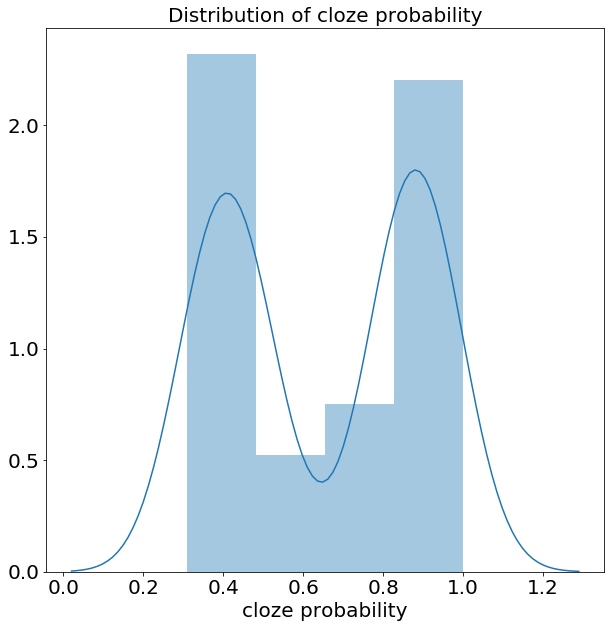

high cloze    51
low cloze     49
Name: cloze_descript, dtype: int64

In [146]:
cloze_distribution(df_extremes_filt)
df_extremes_filt["cloze_descript"].value_counts()
#not much difference if use average mean

In [147]:
#cort_distribution(df_exp_cort)
df_extremes_filt["CoRT_descript"].value_counts()

strong CoRT    100
Name: CoRT_descript, dtype: int64

In [148]:
#also pick sents in 0.5-0.8 range cloze (want even bell-shaped)
#50/50/50 low/med/high

In [149]:
# load in df for middle cloze values (0.5-0.8 range) (note: no RT data)
df_og_middle = pd.read_csv(os.path.join(Defaults.STIM_DIR, 'sentence_validation.csv'))

In [150]:
df_middle_filt = df_og_middle.query('cloze_descript=="medium cloze" and CoRT_descript=="strong CoRT"')
df_middle_filt.shape
#930 w/out cort filter

(170, 10)

In [151]:
df_middle_filt = df_middle_filt.head(50)

In [152]:
#concat extremes and middle cloze dfs
df_exp_cort = pd.concat([df_extremes_filt, df_middle_filt])
df_exp_cort
#all rows w/ CoRT_descript, cloze_descript, cloze_probability

,CoRT_descript,CoRT_mean,CoRT_std,cloze_descript,cloze_probability,dataset,full_sentence,last_word,random_word,rt_mean,rt_std,target_word,trial_type,word_count
0,strong CoRT,NaN,NaN,low cloze,0.46,NaN,Abby|stuck|his|picture|to|her|wall|with|a,tack,lab,947.704394,334.787379,tack,meaningful,NaN
212,strong CoRT,NaN,NaN,high cloze,0.85,NaN,The|box|landed|on|the|ground|with|a|dull,thud,net,943.940663,348.087516,thud,meaningful,NaN
207,strong CoRT,NaN,NaN,high cloze,0.89,NaN,The|boat|passed|easily|under|the,bridge,lodge,783.533490,313.090214,bridge,meaningful,NaN
204,strong CoRT,NaN,NaN,low cloze,0.47,NaN,The|baby's|ice|cream|was|snatched|up|by|the,dog,time,926.604319,360.138670,dog,meaningful,NaN
203,strong CoRT,NaN,NaN,high cloze,0.90,NaN,The|accountant|ironed|a|shirt|before|going|to,work,lies,741.037119,296.519084,work,meaningful,NaN
200,strong CoRT,NaN,NaN,low cloze,0.50,NaN,They|were|startled|by|the|sudden,noise,night,892.765481,284.056398,noise,meaningful,NaN
199,strong CoRT,NaN,NaN,low cloze,0.42,NaN,They|broke|into|the|store|and|began|to,steal,joke,944.772968,384.352324,steal,meaningful,NaN
187,strong CoRT,NaN,NaN,low cloze,0.44,NaN,Stacy|was|not|careful|and|spilled|wine|on|her,dress,noises,882.172703,362.375272,dress,meaningful,NaN
184,strong CoRT,NaN,NaN,high cloze,0.82,NaN,"Soon|after|Janice|stepped|on|the|wet|floor,|she",slipped,crowd,883.110587,364.057414,slipped,meaningful,NaN
181,strong CoRT,NaN,NaN,high cloze,0.92,NaN,She|washed|the|dirty|dishes|in|the,sink,batch,732.956608,294.501672,sink,meaningful,NaN


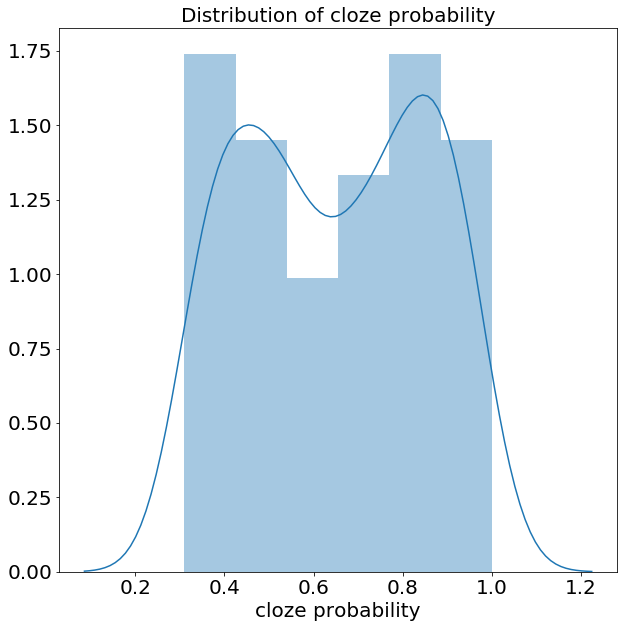

high cloze      51
medium cloze    50
low cloze       49
Name: cloze_descript, dtype: int64

In [153]:
cloze_distribution(df_exp_cort)
df_exp_cort["cloze_descript"].value_counts()

In [154]:
df_exp_cort["CoRT_descript"].value_counts()

strong CoRT    150
Name: CoRT_descript, dtype: int64

## CoRT and non-CoRT word overlap

In [210]:
# how do for all rows in all columns (not manually)?
df_exp_noncort['MAX_TARGET'] = df_exp_noncort['MAX_TARGET'].str.lower()
df_exp_noncort['MAX_TARGET'] = df_exp_noncort['MAX_TARGET'].str.replace(' ', '')

#df_exp_noncort['MIN_TARGET'] = df_exp_noncort['MIN_TARGET'].str.lower()
#df_exp_noncort['MIN_TARGET'] = df_exp_noncort['MIN_TARGET'].str.replace(' ', '')

In [211]:
target_word_cort = df_exp_cort['target_word'].values 
# not have 'last_word' for middle cloze sents (only target and random) but selected 4 only meaningful
# even more overlap if use df_og_extremes, df_og_middle -> prioritize overlap in filt cort? prob not
target_word_noncort = df_exp_noncort['MAX_TARGET'].values #accounting for all possible
# want cue word or target word overlap?

In [212]:
#c = target_word_cort.Intersect(target_word_noncort).ToArray()
len(list(set(target_word_cort) & set(target_word_noncort)))
overlap_words = np.array(list(set(target_word_cort) & set(target_word_noncort)))
overlap_words

# prioritize these rows in filtering df_exp_noncort?
# 61 if not select 4 just meaningful

array(['cry', 'dress', 'neck', 'horn', 'quiet', 'nail', 'dog', 'sword',
       'perfume', 'hoop', 'sound', 'hair', 'trash', 'walk', 'rain',
       'purse', 'room', 'small', 'pull', 'time', 'tag', 'door', 'clean',
       'chalk', 'cough', 'bun', 'milk', 'dirt', 'lid', 'cup', 'circle',
       'gold', 'laugh', 'fire', 'roof', 'hand', 'fight', 'head', 'ball',
       'mouse', 'work', 'wine', 'steal', 'gun', 'shoes', 'sleep', 'sit',
       'face', 'red'], dtype='<U7')

In [213]:
df_overlap = df_exp_noncort.loc[df_exp_noncort['MAX_TARGET'].isin(overlap_words)]
df_overlap = df_overlap.drop_duplicates(subset=['MAX_TARGET'])
df_overlap

,MAX_#G,MIN_#G,MIN_CUE,MAX_#P,MAX_FSG,MIN_FSG,MIN_#P,MAX_TARGET,MAX_CUE,MIN_TARGET
27,147.0,147.0,ACID,26.0,0.177,0.014,2.0,rain,ACID,SOUR
91,146.0,146.0,AIM,47.0,0.322,0.014,2.0,fire,AIM,THROW
130,180.0,180.0,AMUSE,58.0,0.322,0.011,2.0,laugh,AMUSE,SMILE
142,184.0,184.0,ANIMAL,54.0,0.293,0.011,2.0,dog,ANIMAL,RABBIT
175,149.0,149.0,APPLE,31.0,0.208,0.013,2.0,red,APPLE,SEED
187,148.0,148.0,ARGUE,75.0,0.507,0.014,2.0,fight,ARGUE,PARENT
196,143.0,143.0,AROUND,35.0,0.245,0.014,2.0,circle,AROUND,UP
288,99.0,99.0,BALD,22.0,0.222,0.030,3.0,hair,BALD,SCALP
299,152.0,152.0,BANDANNA,26.0,0.171,0.013,2.0,head,BANDANNA,SWEAT
301,145.0,145.0,BANG,40.0,0.276,0.014,2.0,gun,BANG,SMASH


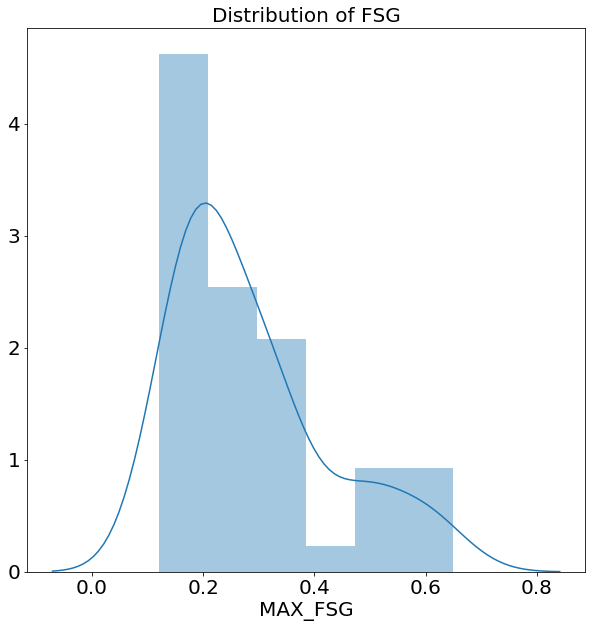

In [214]:
fsg_distribution(df_overlap, 'MAX_FSG')

In [215]:
# how select 100 others? in range 0.5-1.0
df_exp_noncort_rest = df_exp_noncort[df_exp_noncort['MAX_FSG'].between(0.5, 1.0, inclusive=True)]
df_exp_noncort_rest = df_exp_noncort_rest.sample(frac = 1)
df_exp_noncort_rest

,MAX_#G,MIN_#G,MIN_CUE,MAX_#P,MAX_FSG,MIN_FSG,MIN_#P,MAX_TARGET,MAX_CUE,MIN_TARGET
65,156.0,156.0,GLOBE,106.0,0.679,0.013,2.0,world,GLOBE,UNIVERSE
93,150.0,150.0,CAUTIOUS,77.0,0.513,0.013,2.0,careful,CAUTIOUS,SIGN
322,152.0,152.0,BASHFUL,111.0,0.730,0.013,2.0,shy,BASHFUL,BLUSH
179,151.0,151.0,MACARONI,90.0,0.596,0.013,2.0,cheese,MACARONI,SALAD
254,154.0,154.0,AUTUMN,81.0,0.526,0.013,2.0,fall,AUTUMN,TREE
221,143.0,143.0,CLEVER,88.0,0.615,0.014,2.0,smart,CLEVER,STUPID
272,148.0,148.0,HIGH,97.0,0.655,0.014,2.0,low,HIGH,SKY
38,152.0,152.0,ACTRESS,77.0,0.507,0.013,2.0,actor,ACTRESS,PRETTY
123,165.0,165.0,THUNDER,135.0,0.818,0.012,2.0,lightning,THUNDER,LOUD
22,146.0,146.0,SALTINE,122.0,0.836,0.021,3.0,cracker,SALTINE,DRY


In [216]:
df_exp_noncort_rest = df_exp_noncort_rest.head(100)
#.sort_values('MAX_FSG', ascending = False)
#df_exp_noncort_rest

df_exp_noncort_merged = df_exp_noncort_rest.append(df_overlap, ignore_index = True)
df_exp_noncort_merged = df_exp_noncort_merged.sample(frac = 1)
df_exp_noncort_merged

,MAX_#G,MIN_#G,MIN_CUE,MAX_#P,MAX_FSG,MIN_FSG,MIN_#P,MAX_TARGET,MAX_CUE,MIN_TARGET
76,148.0,148.0,LEGS,80.0,0.541,0.014,2.0,arms,LEGS,THIGHS
116,148.0,148.0,THUMB,42.0,0.284,0.027,4.0,hand,THUMB,TOM
42,147.0,147.0,TAXI,79.0,0.537,0.014,2.0,cab,TAXI,RIDE
135,156.0,156.0,SABER,52.0,0.333,0.013,2.0,sword,SABER,FENCE
144,140.0,140.0,COLOGNE,64.0,0.457,0.014,2.0,perfume,COLOGNE,FACE
86,132.0,132.0,LOSER,67.0,0.508,0.015,2.0,winner,LOSER,LAST
37,168.0,168.0,ARM,113.0,0.673,0.018,3.0,leg,ARM,LIMB
106,143.0,143.0,AROUND,35.0,0.245,0.014,2.0,circle,AROUND,UP
96,139.0,139.0,CHOWDER,105.0,0.755,0.014,2.0,clam,CHOWDER,STEW
129,148.0,148.0,LITTER,31.0,0.209,0.014,2.0,trash,LITTER,POLLUTION


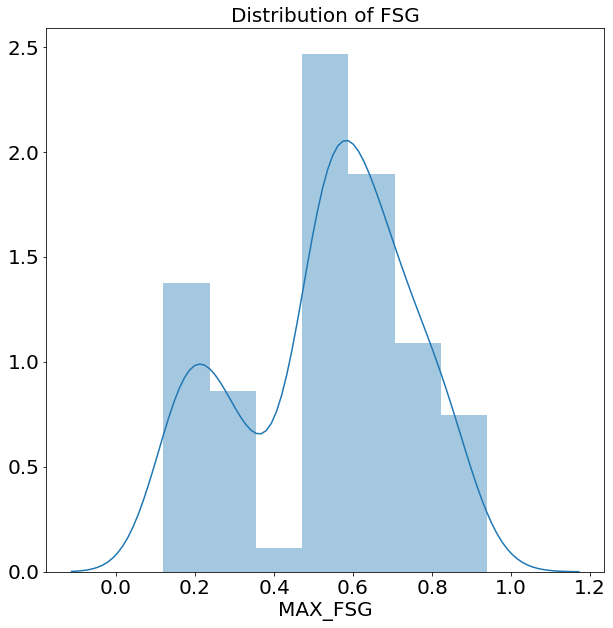

In [217]:
fsg_distribution(df_exp_noncort_merged, 'MAX_FSG')

In [ ]:
# could also sample from dif ranges